In [1]:
%matplotlib inline


# Joint Time-Frequency Scattering Introductory Example
  1. Transform a trumpet signal
  2. Visualize coefficients
  3. Normalize coefficients
  4. Feed to simple PyTorch 1D CNN


## Import the necessary packages



In [2]:
import numpy as np
import torch
import torch.nn as nn
from wavespin import TimeFrequencyScattering1D
from wavespin.visuals import viz_jtfs_2d
from wavespin.toolkit import normalize

## Generate trumpet and create scattering object
load trumpet, duration 2.5 seconds (sampling rate, fs=22050)
generated via `librosa.load(librosa.ex('trumpet'))[0][:int(2.5*22050)]`



In [3]:
x = np.load('librosa_trumpet.npy')
N = x.shape[-1]

# 10 temporal octaves
J = 10
# 8 bandpass wavelets per octave
# J*Q ~= 144 total temporal coefficients in first-order scattering
Q = 16
# scale of temporal invariance, .93 ms (2**11 [samples] / fs [samples/sec])
T = 2**11
# 4 frequential octaves
J_fr = 4
# 2 bandpass wavelets per octave
Q_fr = 1
# scale of frequential invariance, F/Q == 0.5 cycle per octave
F = 8
# average to reduce transform size and impose freq transposition invariance
average_fr = True
# return packed as dict keyed by pair names for easy inspection
out_type = 'dict:array'
# exclude low-energy coefficients (generally uninformative); smallest `j2` also
# take longest to compute
paths_exclude = {'j2': 1}

configs = dict(J=J, shape=N, Q=Q, T=T, J_fr=J_fr, Q_fr=Q_fr, F=F,
               average_fr=average_fr, out_type=out_type,
               paths_exclude=paths_exclude)
jtfs = TimeFrequencyScattering1D(**configs, frontend='numpy')

## Scatter



In [4]:
Scx = jtfs(x)

# print pairs and shapes
for pair, c in Scx.items():
    print(c.shape, '--', pair)

(1, 1, 27) -- S0
(1, 123, 27) -- S1
(1, 16, 27) -- phi_t * phi_f
(1, 96, 27) -- phi_t * psi_f
(1, 80, 27) -- psi_t * phi_f
(1, 477, 27) -- psi_t * psi_f_up
(1, 477, 27) -- psi_t * psi_f_dn


## Visualize



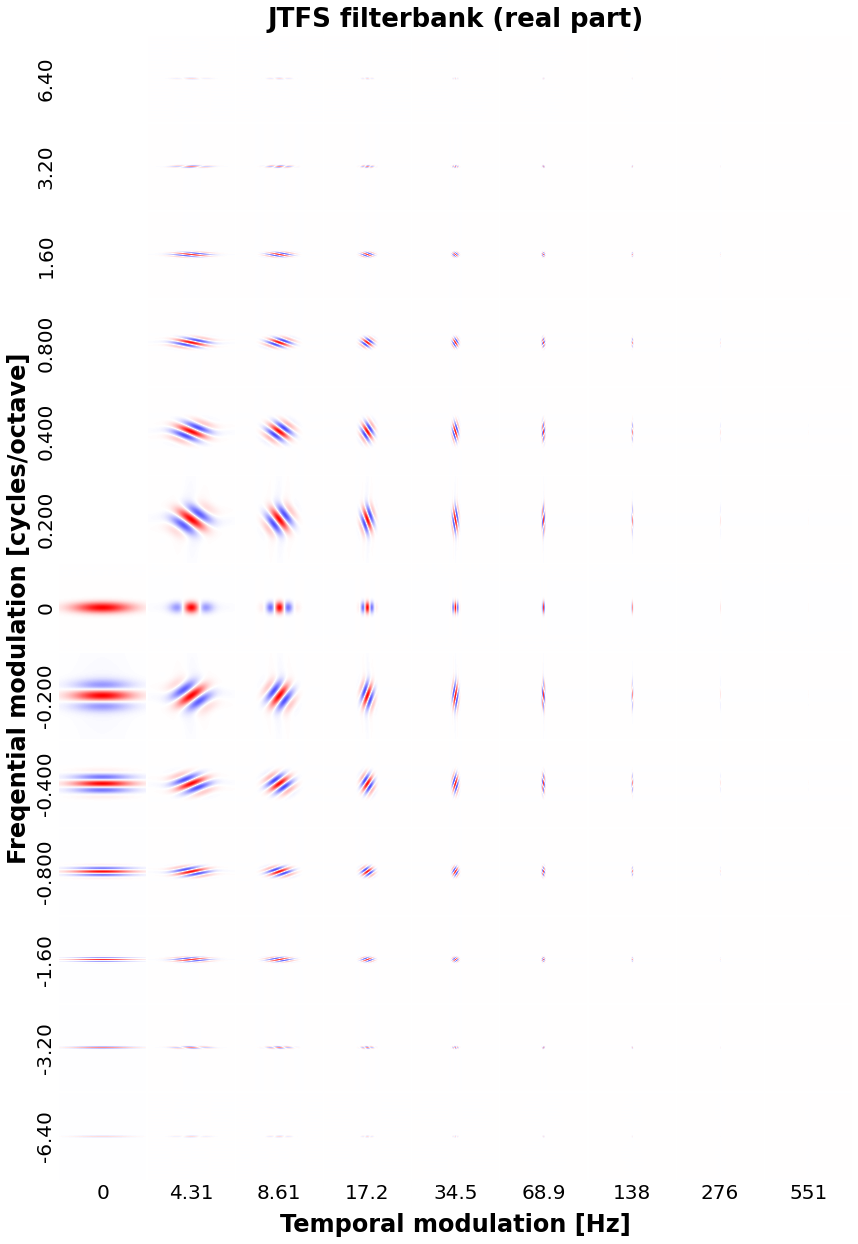

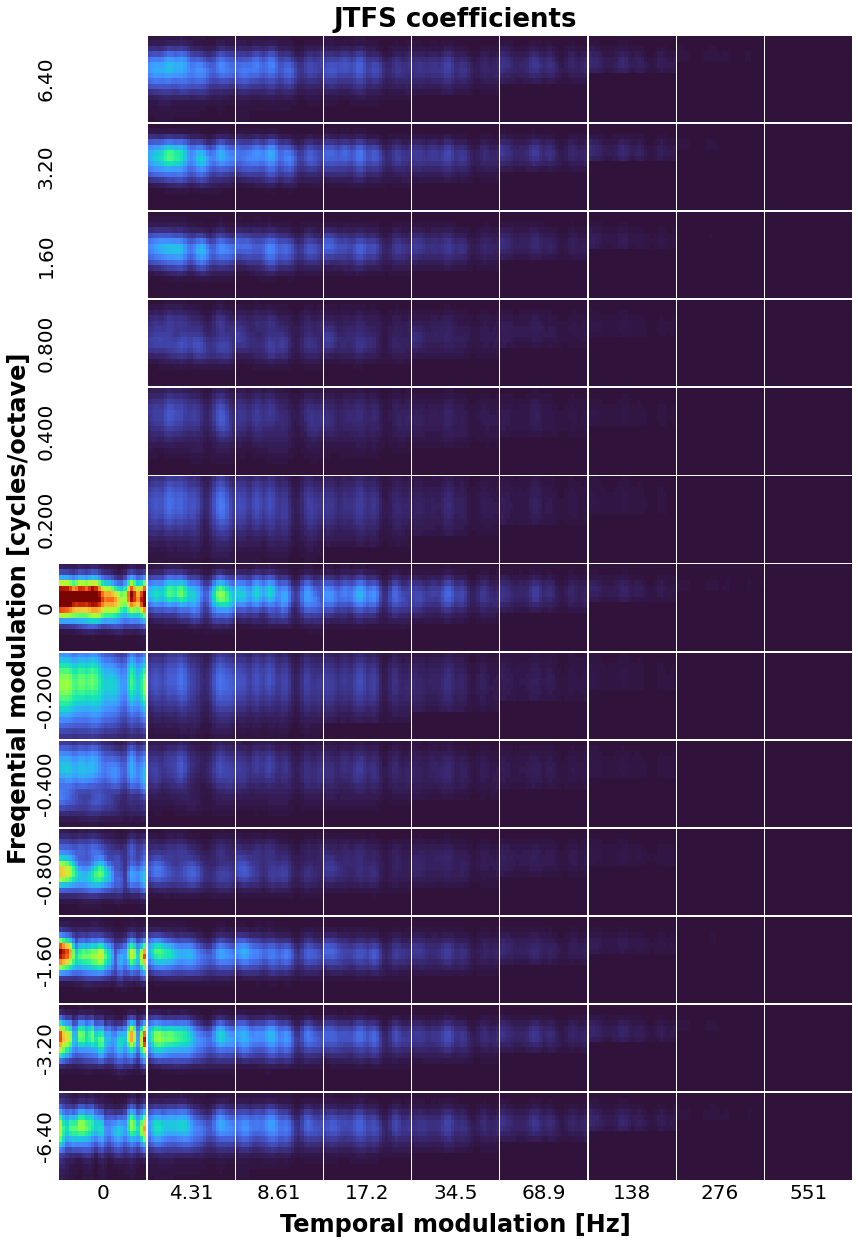

In [5]:
viz_jtfs_2d(jtfs, Scx, viz_coeffs=1, viz_filterbank=1, fs=22050)

## Feed to simple 1D conv-net
minimal network



In [6]:
class Net(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv1d(n_channels, out_channels=32, kernel_size=3)
        self.pool = nn.AdaptiveAvgPool1d(1)  # global avg
        self.fc   = nn.Linear(32, 2)  # e.g. binary classification

    def forward(self, x):
        x = self.pool(self.conv(x)).squeeze(-1)  # drop time dim
        return self.fc(x)

# reinitialize in torch backend
configs['out_type'] = 'array'  # pack everything into one tensor
sct = TimeFrequencyScattering1D(**configs, frontend='torch')
xt = torch.from_numpy(x)
Scx = sct(xt).squeeze(0)[None]  # ensure there is batch dim

# drop zeroth-order, generally uninformative for audio
Scx = Scx[:, 1:]
# channel-norm (mu=None) for 1D convs (axes=-1), log norm (log1p)
Scx = normalize(Scx, mu=None, std_axis=-1, mean_axis=-1)
# print stats
print("{:.1f}, {:.1f} -- mean, std".format(Scx.mean(), Scx.std()))

# initialize network
n_paths = Scx.shape[1]
net = Net(n_paths)

# get outputs, backprop
out = net(Scx)
loss = out.mean()
loss.backward()

# confirm gradients
g = net.conv.weight.grad
print(g.shape, "-- Conv1D weights grad shape")
print(torch.abs(g).mean(), "-- Conv1D weights grad absolute mean")

0.0, 1.0 -- mean, std
torch.Size([32, 1269, 3]) -- Conv1D weights grad shape
tensor(0.0037) -- Conv1D weights grad absolute mean
